# Load library

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import glob
import rasterio
from joblib import dump, load
from datetime import datetime
from extract_func.Extract_PTE_function import *
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

2023-05-02 18:21:58.717764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load ML model

Model which are loaded in here are trained previously with CONUS or Global data between 2017 and 2020. Random Forest model, Deep Learning model.

In [56]:
import tensorflow as tf
model = tf.keras.models.load_model('Model/global_PTE_fixed_hgtlvs_02_20_model/')
rf_model = load('Model/Global_PTE_fixed_hgtlvs_RF.joblib')
alt_model = tf.keras.models.load_model('../GNSS/Global_dat/Full_Global_data/ML/Model/global_PTE_fixed_hgtlvs_by_LAT_model')
glob_model_new = tf.keras.models.load_model('../GNSS/Global_dat/Full_Global_data/ML/Model/global_PTE_fixed_hgtlvs_model_1000batchsize/')

In [57]:
scaler = load('Scaler/global_MinMax_scaler_x.bin')
alt_scaler = load('../GNSS/Global_dat/Full_Global_data/ML/Scaler/global_by_LAT_MinMax_scaler_x.bin')
glob_scaler_x = load('../GNSS/Global_dat/Full_Global_data/ML/Scaler/global_MinMax_scaler_x.bin')

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Hawaii

File path of weather files, unwrapped interferogram, coherence etc.

In [4]:
weather_file_path = '../InSAR/Hawaii/weather_model/weather_files/'
uw_ifg = '../InSAR/Hawaii/products/Extracted/unwrappedPhase/'
coh_ifg = '../InSAR/Hawaii/products/Extracted/coherence/'

In [5]:
dates = glob.glob(uw_ifg+'????????_????????')

In [6]:
dates.sort()

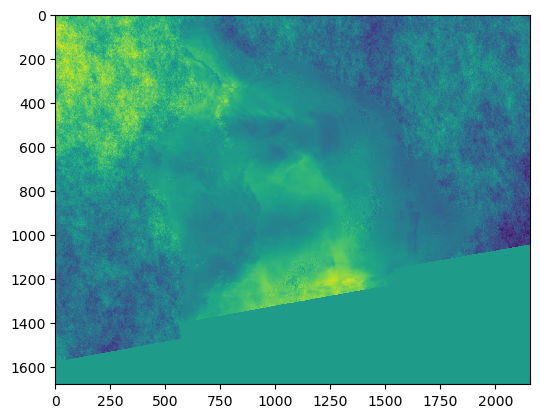

In [32]:
ifg, grid = focus_bound(dates[0], lon_min, lat_min, lon_max,
                            lat_max)
ifg = convert_radian_to_distance(ifg, 5.6/100)
plt.imshow(ifg)
plt.show()

In [7]:
ifg__ = rasterio.open(dates[::2][0])
ifg__.bounds

BoundingBox(left=-159.086666666667, bottom=17.419999999999998, right=-154.101666666667, top=21.1458333333333)

In [23]:
ifg__ = rasterio.open(dates[::2][0])
# lon_min, lat_min, lon_max, lat_max = ifg__.bounds
lon_min=-156.4 
lat_min=18.9
lon_max=-154.6
lat_max=20.3

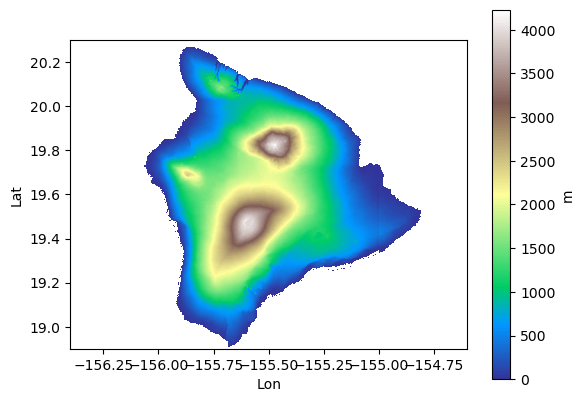

In [24]:
ifg, grid = focus_bound(dates[0], lon_min, lat_min, lon_max,
                            lat_max)
dem, dem_grid = Resamp_rasterio('../InSAR/Hawaii/products/Extracted/DEM/SRTM_3arcsec_uncropped.tif', lon_min,
                                        lat_min, lon_max,
                                        lat_max, ifg)

# print('DEM - done!')
mask = dem<=0
dem[mask] = np.nan
plt.imshow(dem, cmap='terrain', extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='m')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()

Create a list to keep track of the interferogram that have an average coherence of a specific theshold (0.8). The coherence can keep track of the quality of each pixel from unwrapped interferogram.

In [10]:
coh_list = []
ifg, grid = focus_bound(dates[0], lon_min, lat_min, lon_max,
                            lat_max)
dem, dem_grid = Resamp_rasterio('../InSAR/Hawaii/products/Extracted/DEM/SRTM_3arcsec_uncropped.tif', lon_min,
                                        lat_min, lon_max,
                                        lat_max, ifg)

# print('DEM - done!')
mask = dem<=0
for path in glob.glob(coh_ifg+'*[0-9].vrt'):
    
    coh, _ = Resamp_rasterio(path, lon_min, lat_min, lon_max, lat_max, ifg)
    coh[coh==0] = np.nan
    coh[mask] = np.nan
    avg_coh = np.nanmean(coh)
    # print(avg_coh)
    if avg_coh > 0.8:
        coh_list.append(path.split('/')[-1].split('.')[0])
    else:
        pass

/tmp/ipykernel_1982/192153604.py:15: RuntimeWarning: Mean of empty slice
  avg_coh = np.nanmean(coh)


In [11]:
coh_list.sort()
coh_list

['20190708_20190702',
 '20190714_20190708',
 '20190720_20190708',
 '20190720_20190714',
 '20190726_20190720',
 '20190801_20190726',
 '20190813_20190807',
 '20190819_20190813',
 '20190825_20190819',
 '20190831_20190825',
 '20190906_20190825',
 '20190906_20190831',
 '20190912_20190906',
 '20190918_20190906',
 '20190918_20190912',
 '20190930_20190918',
 '20191006_20190930',
 '20191012_20191006',
 '20191018_20191006',
 '20191018_20191012',
 '20191024_20191012',
 '20191024_20191018',
 '20191105_20191024',
 '20191111_20191105',
 '20191117_20191105',
 '20191117_20191111',
 '20191129_20191123']

In [12]:
ifg_list = [e for e in coh_list if e in [i.split('/')[-1] for i in dates]]
ifg_list.sort()
ifg_list

['20190708_20190702',
 '20190714_20190708',
 '20190720_20190708',
 '20190720_20190714',
 '20190726_20190720',
 '20190801_20190726',
 '20190813_20190807',
 '20190819_20190813',
 '20190825_20190819',
 '20190831_20190825',
 '20190906_20190825',
 '20190906_20190831',
 '20190912_20190906',
 '20190918_20190906',
 '20190918_20190912',
 '20190930_20190918',
 '20191006_20190930',
 '20191012_20191006',
 '20191018_20191006',
 '20191018_20191012',
 '20191024_20191012',
 '20191024_20191018',
 '20191105_20191024',
 '20191111_20191105',
 '20191117_20191105',
 '20191117_20191111',
 '20191129_20191123']

In [13]:
wm_date = [i.split('_') for i in ifg_list]
wm_date = [item for sublist in wm_date for item in sublist]
wm_date.sort()
wm_date

['20190702',
 '20190708',
 '20190708',
 '20190708',
 '20190714',
 '20190714',
 '20190720',
 '20190720',
 '20190720',
 '20190726',
 '20190726',
 '20190801',
 '20190807',
 '20190813',
 '20190813',
 '20190819',
 '20190819',
 '20190825',
 '20190825',
 '20190825',
 '20190831',
 '20190831',
 '20190906',
 '20190906',
 '20190906',
 '20190906',
 '20190912',
 '20190912',
 '20190918',
 '20190918',
 '20190918',
 '20190930',
 '20190930',
 '20191006',
 '20191006',
 '20191006',
 '20191012',
 '20191012',
 '20191012',
 '20191018',
 '20191018',
 '20191018',
 '20191024',
 '20191024',
 '20191024',
 '20191105',
 '20191105',
 '20191105',
 '20191111',
 '20191111',
 '20191117',
 '20191117',
 '20191123',
 '20191129']

20190708_20190702


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20190720_20190708


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20190726_20190720


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20190813_20190807


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20190825_20190819


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20190906_20190825


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20190912_20190906


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20190918_20190912


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20191006_20190930


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20191018_20191006


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20191024_20191012


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20191105_20191024


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20191117_20191105


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


20191129_20191123


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


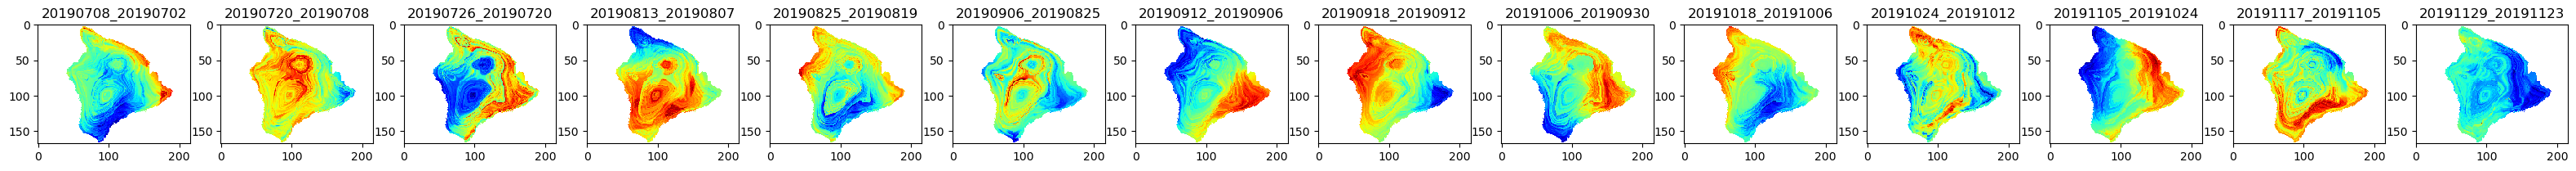

In [63]:
rf_TD_list = []
fig, axes = plt.subplots(1, len(ifg_list[::2]), figsize=(40,15))
for i, date in enumerate(ifg_list[::2]):
    print(date)
    # print('IFG - done!')
    if i == 0:
        ifg, grid = focus_bound(uw_ifg + date, lon_min, lat_min, lon_max,
                            lat_max)
        dem, dem_grid = Resamp_rasterio('../InSAR/Hawaii/products/Extracted/DEM/SRTM_3arcsec_uncropped.tif', lon_min,
                                        lat_min, lon_max,
                                        lat_max, ifg)
        # print('DEM - done!')
        mask = dem<=0
        los, _ = Resamp_rasterio('../InSAR/Hawaii/Angle/los.rdr', lon_min, lat_min, lon_max, lat_max, ifg)
    else:
        pass
    lon = dem_grid[:,0].reshape(ifg.shape)
    lat = dem_grid[:,-1].reshape(ifg.shape)

    
    # # Get date and wm
    date1, date2 = get_datetime(date)
    # dem[mask] = np.nan
    x = lon[::10,::10][0,:]
    x.sort()
    y = lat[::10,::10][:,0]
    y.sort()
    XY = np.meshgrid(x,y)
    wm1_1, wm1_2, minutes= getWM(date1, 'T04_31_00', weather_file_path)
    wm2_1, wm2_2, minutes= getWM(date2, 'T04_31_00', weather_file_path)
    P1, T1, e1 = interpByTime(wm1_1, wm1_2, minutes, 'all')
    P2, T2, e2 = interpByTime(wm2_1, wm2_2, minutes, 'all')
    P1, T1, e1 = P1.interp(x=x, y=y), T1.interp(x=x, y=y), e1.interp(x=x, y=y)
    P2, T2, e2 = P2.interp(x=x, y=y), T2.interp(x=x, y=y), e2.interp(x=x, y=y)
    
    Day_1 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    Day_2 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    # print('Done!')
    # print('')
    # print('Make prediction...')
    predict_day1, predict_day2 = rf_model.predict(Day_1), rf_model.predict(Day_2)
    TD = (predict_day1 - predict_day2).reshape(dem[::10,::10].shape)
    TD = TD / np.cos(np.radians(los[::10,::10]))
    TD[mask[::10,::10]] = np.nan
    rf_TD_list.append(TD)
    # print('Done!')
    
    axes[i].imshow(TD, cmap='jet')
   
    axes[i].title.set_text(date)
plt.show()

20190708_20190702
 154/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 152/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 669us/step
20190720_20190708
 152/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 152/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 663us/step
20190726_20190720
 161/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 153/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 667us/step
20190813_20190807
 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 674us/step
20190825_20190819
 149/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 149/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 673us/step
20190906_20190825
 155/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 158/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 635us/step
20190912_20190906
 153/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 152/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 652us/step
20190918_20190912
 151/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 151/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 672us/step
20191006_20190930
 145/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 150/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 675us/step
20191018_20191006
 145/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 152/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 667us/step
20191024_20191012
 152/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 151/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 664us/step
20191105_20191024
 151/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 154/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 652us/step
20191117_20191105
 157/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 157/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 649us/step
20191129_20191123
 155/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 155/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 650us/step


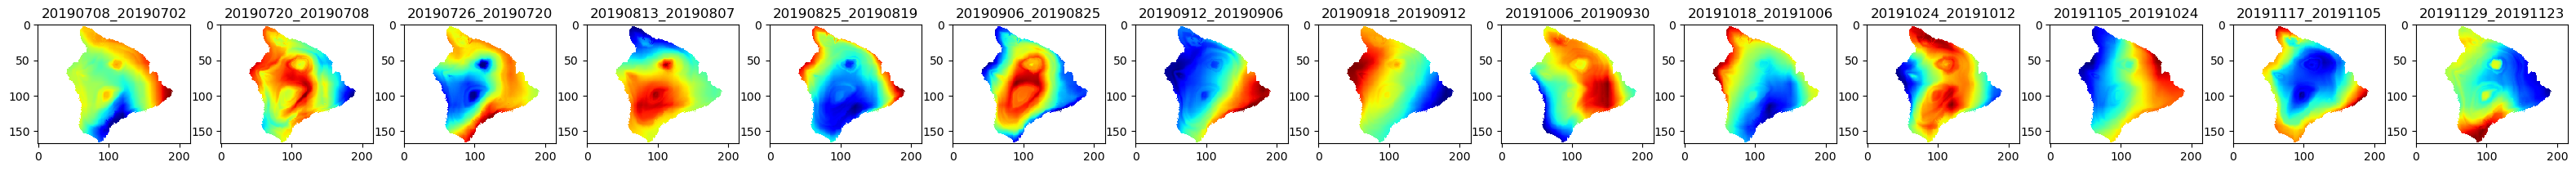

In [49]:
TD_list = []
fig, axes = plt.subplots(1, len(ifg_list[::2]), figsize=(40,15))
for i, date in enumerate(ifg_list[::2]):
    print(date)
    # print('IFG - done!')
    if i == 0:
        ifg, grid = focus_bound(uw_ifg + date, lon_min, lat_min, lon_max,
                            lat_max)
        dem, dem_grid = Resamp_rasterio('../InSAR/Hawaii/products/Extracted/DEM/SRTM_3arcsec_uncropped.tif', lon_min,
                                        lat_min, lon_max,
                                        lat_max, ifg)
        # print('DEM - done!')
        mask = dem<=0
        los, _ = Resamp_rasterio('../InSAR/Hawaii/Angle/los.rdr', lon_min, lat_min, lon_max, lat_max, ifg)
    else:
        pass
    lon = dem_grid[:,0].reshape(ifg.shape)
    lat = dem_grid[:,-1].reshape(ifg.shape)

    
    # # Get date and wm
    date1, date2 = get_datetime(date)
    dem[mask] = np.nan
    x = lon[::10,::10][0,:]
    x.sort()
    y = lat[::10,::10][:,0]
    y.sort()
    XY = np.meshgrid(x,y)
    wm1_1, wm1_2, minutes= getWM(date1, 'T04_31_00', weather_file_path)
    wm2_1, wm2_2, minutes= getWM(date2, 'T04_31_00', weather_file_path)
    P1, T1, e1 = interpByTime(wm1_1, wm1_2, minutes, 'all')
    P2, T2, e2 = interpByTime(wm2_1, wm2_2, minutes, 'all')
    P1, T1, e1 = P1.interp(x=x, y=y), T1.interp(x=x, y=y), e1.interp(x=x, y=y)
    P2, T2, e2 = P2.interp(x=x, y=y), T2.interp(x=x, y=y), e2.interp(x=x, y=y)
    
    Day_1 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    Day_2 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    # print('Done!')
    # print('')
    # print('Make prediction...')
    predict_day1, predict_day2 = model.predict(scaler.transform(Day_1)), model.predict(scaler.transform(Day_2))
    TD = (predict_day1 - predict_day2).reshape(dem[::10,::10].shape)
    TD = TD / np.cos(np.radians(los[::10,::10]))
    TD_list.append(TD)
    # print('Done!')
    
    axes[i].imshow(TD, cmap='jet')
   
    axes[i].title.set_text(date)
plt.show()
    

20190708_20190702
 175/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 184/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 551us/step
20190720_20190708
 168/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 184/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 554us/step
20190726_20190720
 183/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 190/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 535us/step
20190813_20190807
 188/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 191/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 528us/step
20190825_20190819
 188/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 192/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 527us/step
20190906_20190825
 190/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 192/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 533us/step
20190912_20190906
 189/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 190/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 529us/step
20190918_20190912
 191/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 190/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 531us/step
20191006_20190930
 185/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 189/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 540us/step
20191018_20191006
 191/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 198/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 524us/step
20191024_20191012
 190/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 193/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 525us/step
20191105_20191024
 183/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 189/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 524us/step
20191117_20191105
 190/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 192/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 526us/step
20191129_20191123
 188/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 190/1134 [====>.........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 530us/step


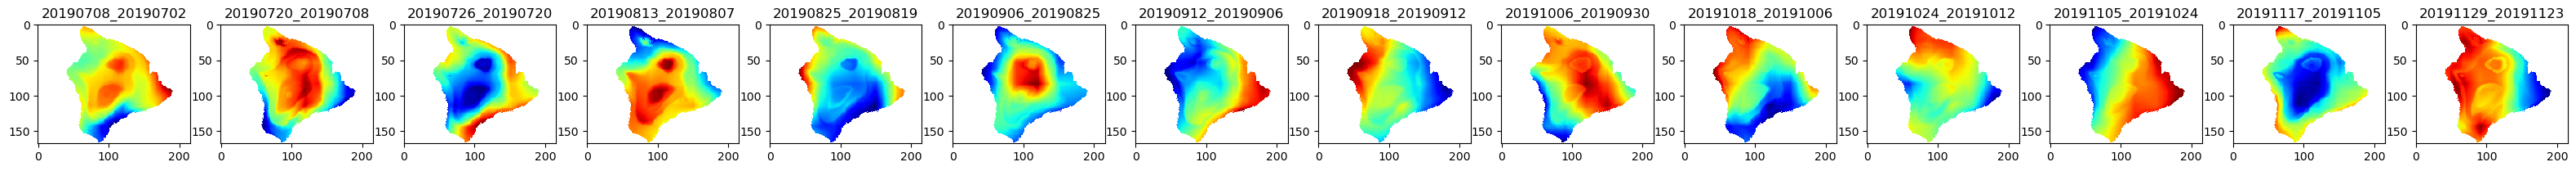

In [50]:
alt_TD_list = []
fig, axes = plt.subplots(1, len(ifg_list[::2]), figsize=(40,15))
for i, date in enumerate(ifg_list[::2]):
    print(date)
    # print('IFG - done!')
    if i == 0:
        ifg, grid = focus_bound(uw_ifg + date, lon_min, lat_min, lon_max,
                            lat_max)
        dem, dem_grid = Resamp_rasterio('../InSAR/Hawaii/products/Extracted/DEM/SRTM_3arcsec_uncropped.tif', lon_min,
                                        lat_min, lon_max,
                                        lat_max, ifg)
        # print('DEM - done!')
        mask = dem<=0
        los, _ = Resamp_rasterio('../InSAR/Hawaii/Angle/los.rdr', lon_min, lat_min, lon_max, lat_max, ifg)
    else:
        pass
    lon = dem_grid[:,0].reshape(ifg.shape)
    lat = dem_grid[:,-1].reshape(ifg.shape)

    
    # # Get date and wm
    date1, date2 = get_datetime(date)
    dem[mask] = np.nan
    x = lon[::10,::10][0,:]
    x.sort()
    y = lat[::10,::10][:,0]
    y.sort()
    XY = np.meshgrid(x,y)
    wm1_1, wm1_2, minutes= getWM(date1, 'T04_31_00', weather_file_path)
    wm2_1, wm2_2, minutes= getWM(date2, 'T04_31_00', weather_file_path)
    P1, T1, e1 = interpByTime(wm1_1, wm1_2, minutes, 'all')
    P2, T2, e2 = interpByTime(wm2_1, wm2_2, minutes, 'all')
    P1, T1, e1 = P1.interp(x=x, y=y), T1.interp(x=x, y=y), e1.interp(x=x, y=y)
    P2, T2, e2 = P2.interp(x=x, y=y), T2.interp(x=x, y=y), e2.interp(x=x, y=y)
    
    Day_1 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    Day_2 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    # print('Done!')
    # print('')
    # print('Make prediction...')
    predict_day1, predict_day2 = alt_model.predict(alt_scaler.transform(Day_1)), alt_model.predict(alt_scaler.transform(Day_2))
    TD = (predict_day1 - predict_day2).reshape(dem[::10,::10].shape)
    TD = TD / np.cos(np.radians(los[::10,::10]))
    alt_TD_list.append(TD)
    # print('Done!')
    
    axes[i].imshow(TD, cmap='jet')
   
    axes[i].title.set_text(date)
plt.show()
    

20190708_20190702
   1/1134 [..............................] - ETA: 2:08

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 135/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 750us/step
20190720_20190708
 134/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 135/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 748us/step
20190726_20190720
 135/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 137/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 751us/step
20190813_20190807
 138/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 147/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 688us/step
20190825_20190819
 140/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 672us/step
20190906_20190825
 149/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 146/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 676us/step
20190912_20190906
 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 152/1134 [===>..........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 671us/step
20190918_20190912
 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 679us/step
20191006_20190930
 147/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 678us/step
20191018_20191006
 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 145/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 703us/step
20191024_20191012
 148/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 149/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 672us/step
20191105_20191024
 138/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 149/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 673us/step
20191117_20191105
 149/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 145/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 691us/step
20191129_20191123
 149/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 144/1134 [==>...........................] - ETA: 0s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 1s 692us/step


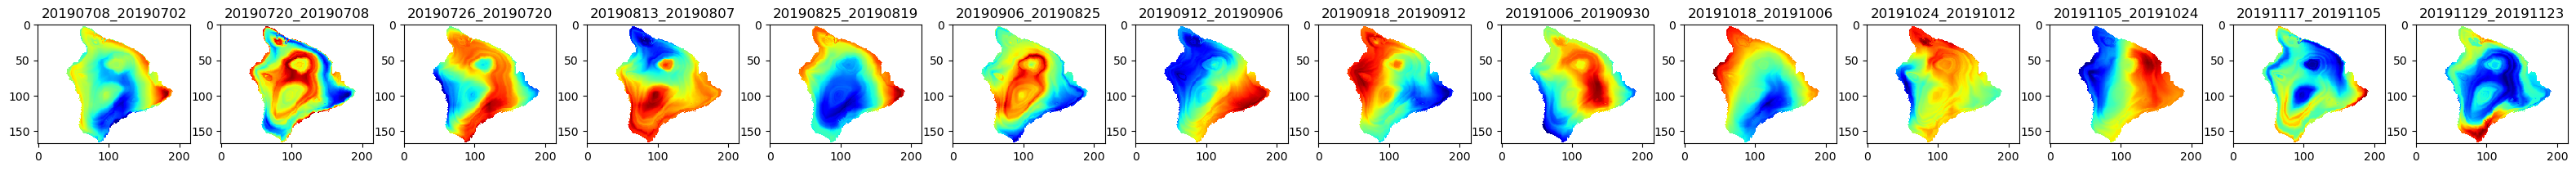

In [58]:
new_alt_TD_list = []
fig, axes = plt.subplots(1, len(ifg_list[::2]), figsize=(40,15))
for i, date in enumerate(ifg_list[::2]):
    print(date)
    # print('IFG - done!')
    if i == 0:
        ifg, grid = focus_bound(uw_ifg + date, lon_min, lat_min, lon_max,
                            lat_max)
        dem, dem_grid = Resamp_rasterio('../InSAR/Hawaii/products/Extracted/DEM/SRTM_3arcsec_uncropped.tif', lon_min,
                                        lat_min, lon_max,
                                        lat_max, ifg)
        # print('DEM - done!')
        mask = dem<=0
        los, _ = Resamp_rasterio('../InSAR/Hawaii/Angle/los.rdr', lon_min, lat_min, lon_max, lat_max, ifg)
    else:
        pass
    lon = dem_grid[:,0].reshape(ifg.shape)
    lat = dem_grid[:,-1].reshape(ifg.shape)

    
    # # Get date and wm
    date1, date2 = get_datetime(date)
    dem[mask] = np.nan
    x = lon[::10,::10][0,:]
    x.sort()
    y = lat[::10,::10][:,0]
    y.sort()
    XY = np.meshgrid(x,y)
    wm1_1, wm1_2, minutes= getWM(date1, 'T04_31_00', weather_file_path)
    wm2_1, wm2_2, minutes= getWM(date2, 'T04_31_00', weather_file_path)
    P1, T1, e1 = interpByTime(wm1_1, wm1_2, minutes, 'all')
    P2, T2, e2 = interpByTime(wm2_1, wm2_2, minutes, 'all')
    P1, T1, e1 = P1.interp(x=x, y=y), T1.interp(x=x, y=y), e1.interp(x=x, y=y)
    P2, T2, e2 = P2.interp(x=x, y=y), T2.interp(x=x, y=y), e2.interp(x=x, y=y)
    
    Day_1 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    Day_2 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    # print('Done!')
    # print('')
    # print('Make prediction...')
    predict_day1, predict_day2 = glob_model_new.predict(alt_scaler.transform(Day_1)), glob_model_new.predict(alt_scaler.transform(Day_2))
    TD = (predict_day1 - predict_day2).reshape(dem[::10,::10].shape)
    TD = TD / np.cos(np.radians(los[::10,::10]))
    new_alt_TD_list.append(TD)
    # print('Done!')
    
    axes[i].imshow(TD, cmap='jet')
   
    axes[i].title.set_text(date)
plt.show()
    

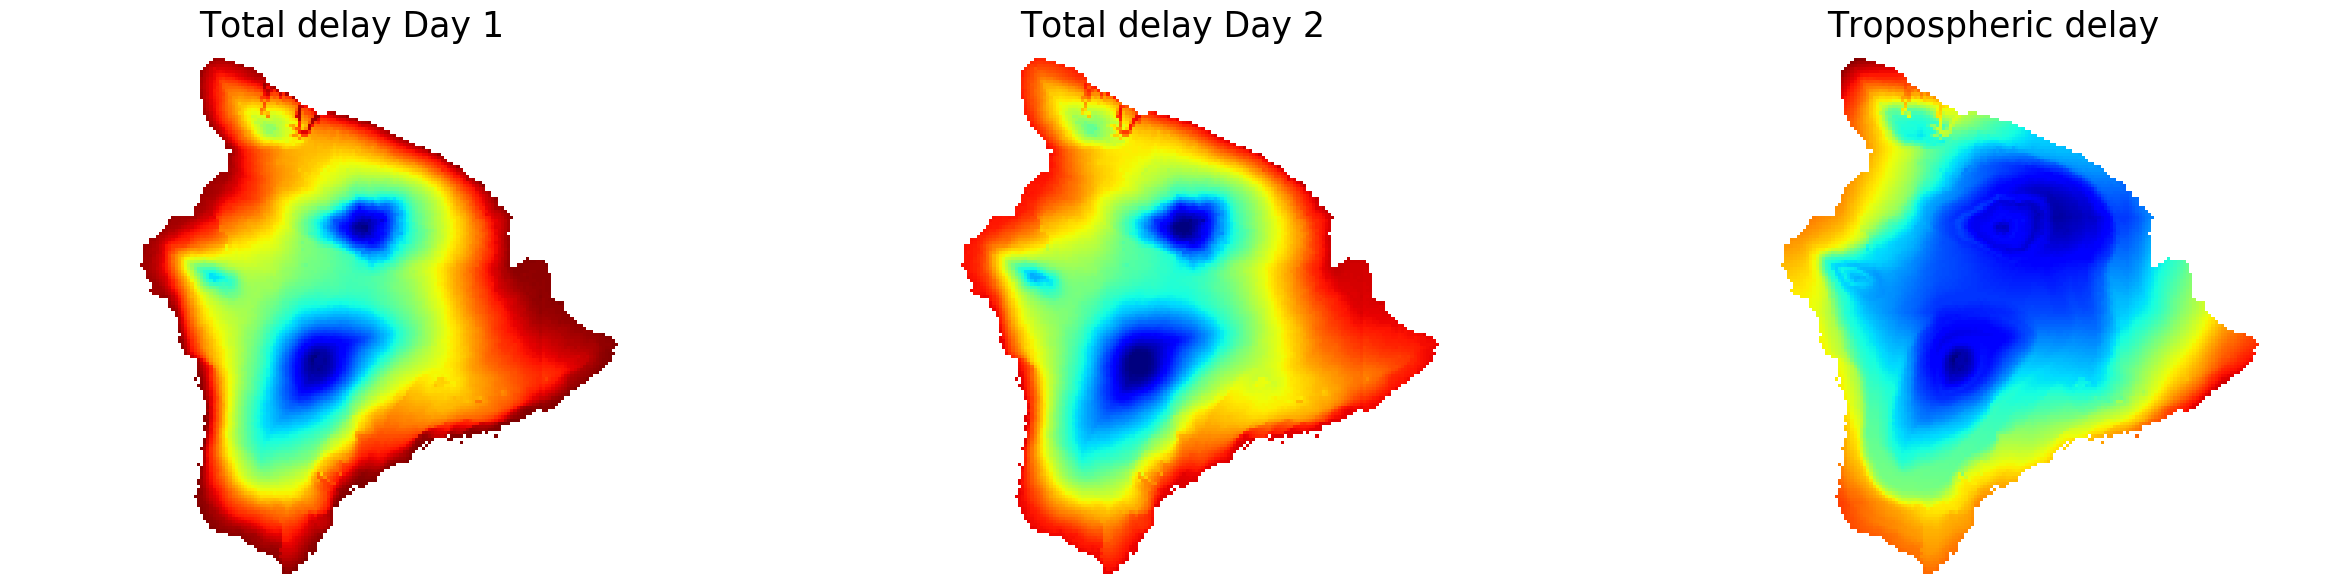

In [15]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
axes[0].imshow(predict_day1.reshape(dem[::10,::10].shape), cmap='jet')
axes[0].set_title('Total delay Day 1', fontsize=25)
axes[1].imshow(predict_day2.reshape(dem[::10,::10].shape), cmap='jet', vmin=np.nanmin(predict_day1), vmax=np.nanmax(predict_day1))
axes[1].set_title('Total delay Day 2', fontsize=25)
axes[2].imshow((predict_day1 - predict_day2).reshape(dem[::10,::10].shape), cmap='jet')
axes[2].set_title('Tropospheric delay', fontsize=25)
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
plt.show()

In [51]:
for i, date in enumerate(ifg_list[::2]):
    ifg_path = uw_ifg+date
    print(ifg_path)

../InSAR/Hawaii/products/Extracted/unwrappedPhase/20190708_20190702
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20190720_20190708
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20190726_20190720
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20190813_20190807
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20190825_20190819
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20190906_20190825
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20190912_20190906
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20190918_20190912
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20191006_20190930
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20191018_20191006
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20191024_20191012
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20191105_20191024
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20191117_20191105
../InSAR/Hawaii/products/Extracted/unwrappedPhase/20191129_20191123


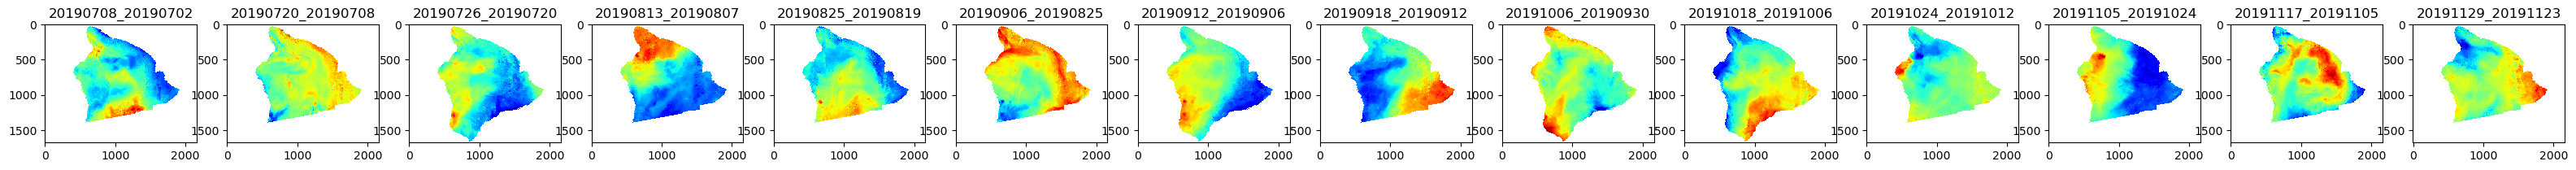

In [52]:
IFG = []
fig, axes = plt.subplots(1, len(ifg_list[::2]), figsize=(40,15))
for i, date in enumerate(ifg_list[::2]):
    ifg_path = uw_ifg+date
    # coh_path = coh_ifg+date+'.vrt'
    # with rasterio.open(coh_path) as file:
    #     coh = file.read(1)
    #     coh_mask = coh<0.8
    try:
        ifg, grid = focus_bound(ifg_path, lon_min, lat_min, lon_max, lat_max)
        # coh, _ = Resamp_rasterio(coh_path , lon_min, lat_min, lon_max,
        #                     lat_max, ifg)
        # coh_mask = coh<0.7
        ifg = convert_radian_to_distance(ifg, 5.6/100)
        ifg[ifg==0.0] = np.nan
        ifg[mask] = np.nan
        # ifg[coh_mask] = np.nan
        a = axes[i].imshow(ifg, cmap='jet')
        axes[i].title.set_text(date)
        IFG.append(ifg)
    except:
        continue
    """ Iterate column's axes"""
# axes.colorbar(a, label='(m)', orientation='horizontal')
plt.show()

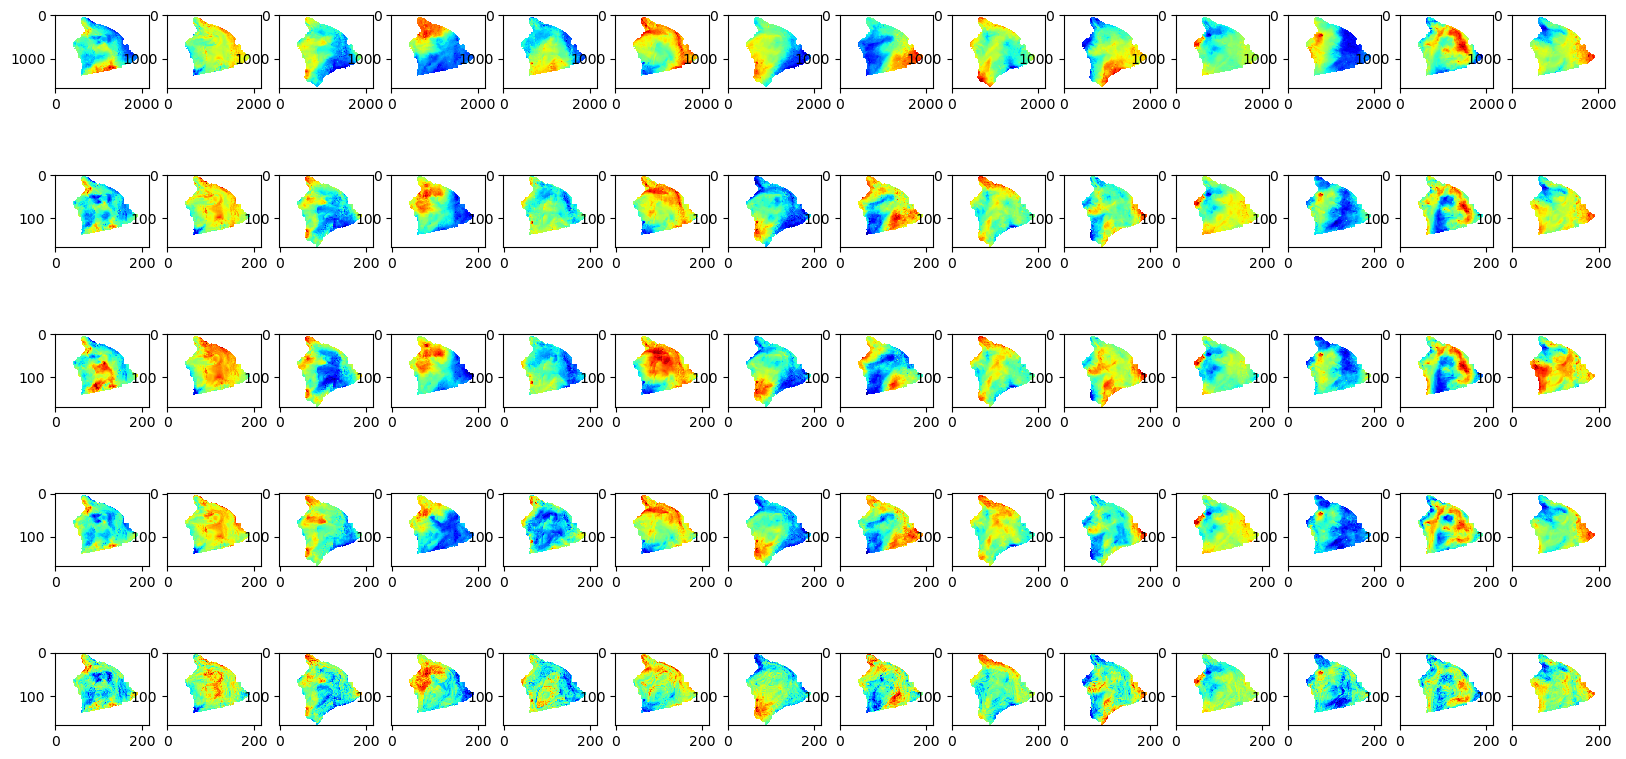

In [64]:
fig, axes = plt.subplots(5, len(ifg_list[::2]), figsize=(20,10))
for i, ifg_plot in enumerate(IFG):
    axes[0, i].imshow(ifg_plot - ifg_plot[1000,1800], cmap='jet')
    axes[1, i].imshow((ifg_plot[::10,::10]+TD_list[i])-(ifg_plot[::10,::10]+TD_list[i])[100,180], cmap='jet')
    axes[2, i].imshow((ifg_plot[::10,::10]+alt_TD_list[i]) - (ifg_plot[::10,::10]+alt_TD_list[i])[100,180], cmap='jet')
    axes[3, i].imshow((ifg_plot[::10,::10]+new_alt_TD_list[i]) - (ifg_plot[::10,::10]+new_alt_TD_list[i])[100,180], cmap='jet')
    axes[4, i].imshow((ifg_plot[::10,::10]+rf_TD_list[i]) - (ifg_plot[::10,::10]+rf_TD_list[i])[100,180], cmap='jet')
plt.show()

In [43]:
wm = xr.load_dataset('../InSAR/Hawaii/weather_model/weather_files/ERA-5_2019_06_30_T04_00_00_15N_26N_162W_150W.nc')
wm_clip = wm.where((wm.x<lon_max) &(wm.x>lon_min)&(wm.y<lat_max)&(wm.y>lat_min), drop=True)
XY = np.meshgrid(wm_clip.x.values, wm_clip.y.values)
XY[0].shape

(5, 8)

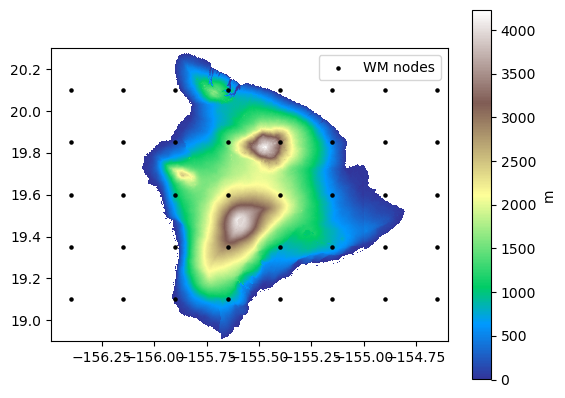

In [44]:
plt.imshow(dem, extent=[lon_min, lon_max, lat_min, lat_max], cmap='terrain')
plt.colorbar(label='m')
plt.scatter(XY[0], XY[1], label='WM nodes', s=5, c='black')
plt.legend()
plt.show()

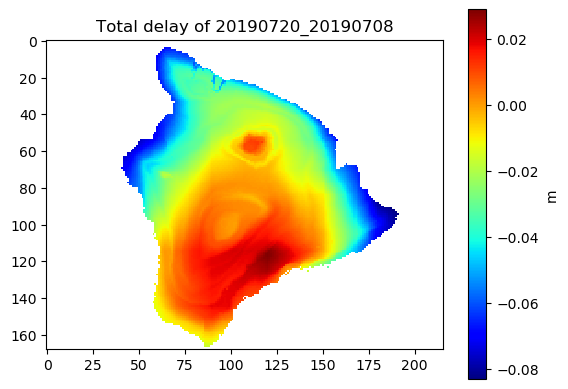

In [45]:
plt.imshow(-TD_list[2] + TD_list[2][75,100] , cmap='jet')
plt.title('Total delay of {}'.format(ifg_list[2]))
plt.colorbar(label='m')
plt.show()

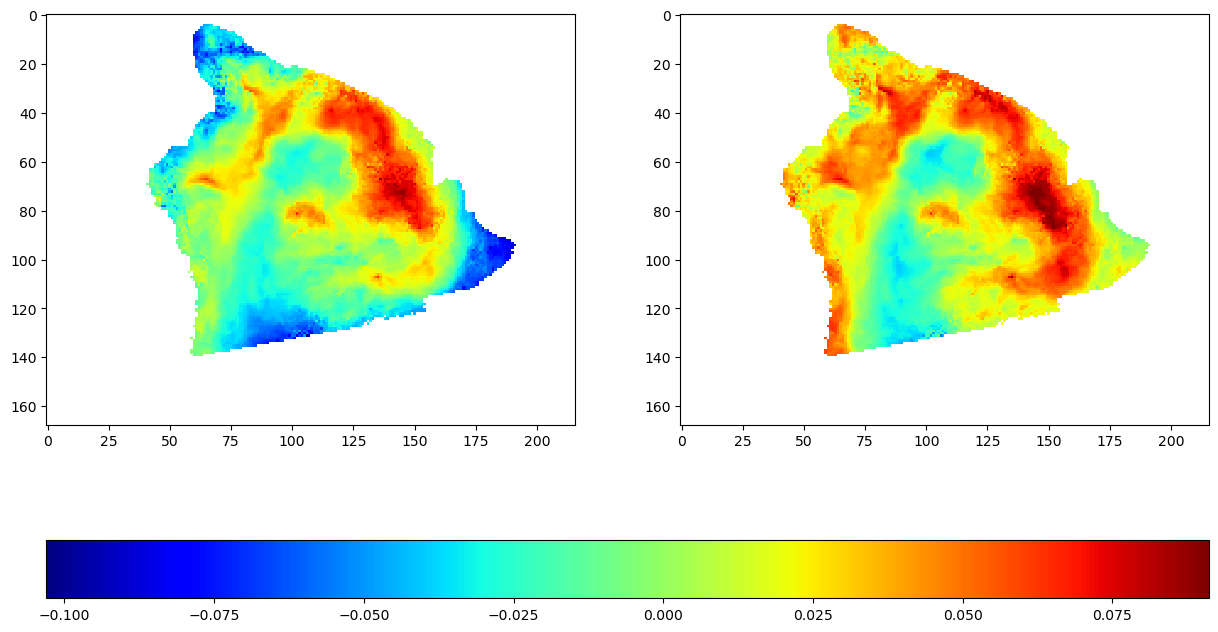

In [24]:
no = 6
fig, axes = plt.subplots(1, 2, figsize=(15,10))
a = axes[0].imshow(IFG[no][::10,::10] - IFG[no][::10,::10][75,100], cmap='jet')
fig.colorbar(a, ax = axes, orientation='horizontal')
b = axes[1].imshow((IFG[no][::10,::10] + TD_list[no]) - ((IFG[no][::10,::10] + TD_list[no])[75,100]) , cmap='jet', vmin = np.nanmin(IFG[no][::10,::10] - IFG[no][::10,::10][75,100]), vmax = np.nanmax(IFG[no][::10,::10] - IFG[no][::10,::10][75,100]))
# fig.colorbar(b)
plt.show()

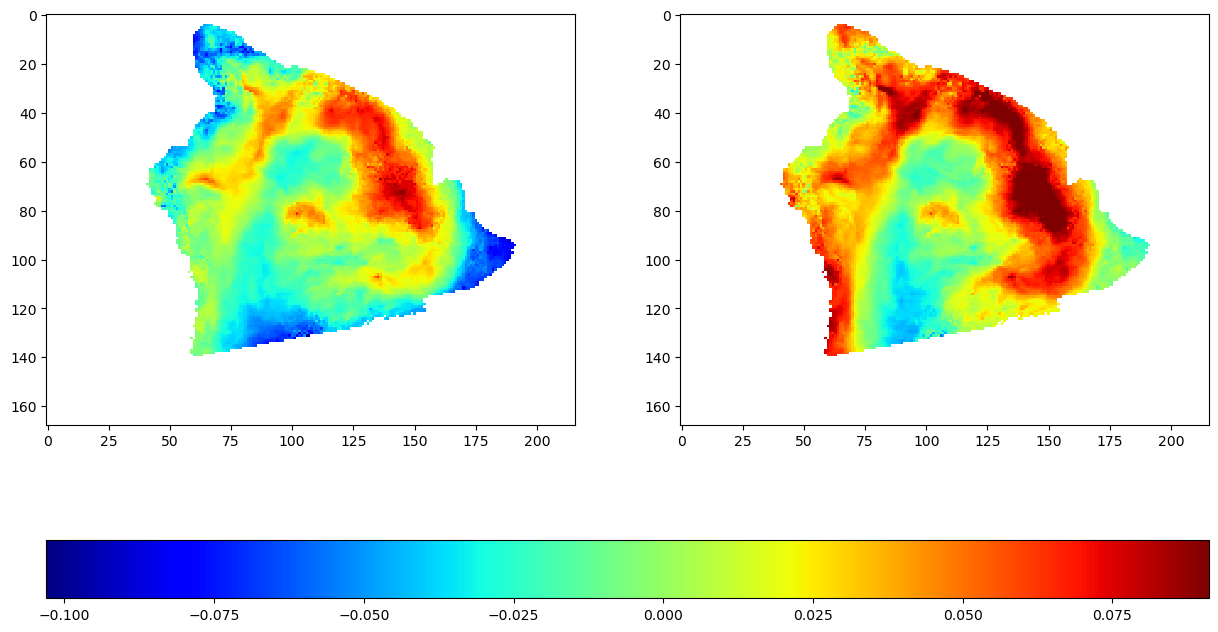

In [46]:
no = 6
fig, axes = plt.subplots(1, 2, figsize=(15,10))
a = axes[0].imshow(IFG[no][::10,::10] - IFG[no][::10,::10][75,100], cmap='jet')
fig.colorbar(a, ax = axes, orientation='horizontal')
b = axes[1].imshow((IFG[no][::10,::10] + alt_TD_list[no]) - ((IFG[no][::10,::10] + alt_TD_list[no])[75,100]) , cmap='jet', vmin = np.nanmin(IFG[no][::10,::10] - IFG[no][::10,::10][75,100]), vmax = np.nanmax(IFG[no][::10,::10] - IFG[no][::10,::10][75,100]))
# fig.colorbar(b)
plt.show()

In [25]:
np.nanstd(IFG[no][::10,::10] - IFG[no][::10,::10][75,100]), np.nanstd((IFG[no][::10,::10] + TD_list[no]) - (IFG[no][::10,::10] + TD_list[no])[75,100])

(0.03287002, 0.028299872)

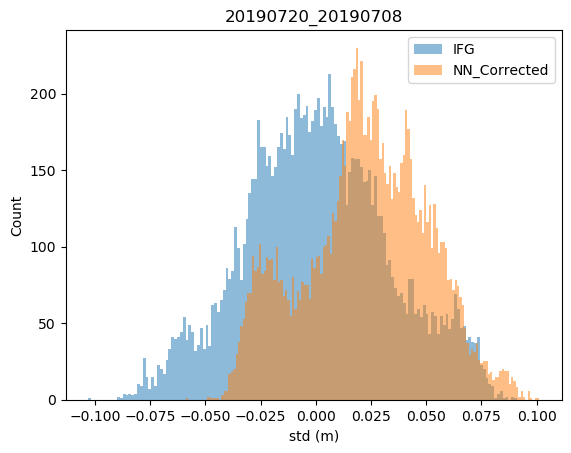

In [48]:
plt.hist((IFG[no][::10,::10] - IFG[no][::10,::10][75,100]).ravel(), bins=150, label='IFG', alpha=0.5)
plt.hist(((IFG[no][::10,::10] + TD_list[no]) - ((IFG[no][::10,::10] + TD_list[no])[75,100])).ravel(), bins=150, label='NN_Corrected', alpha=0.5)
plt.xlabel('std (m)')
plt.ylabel('Count')
plt.title(ifg_list[2])
plt.legend()
plt.show()

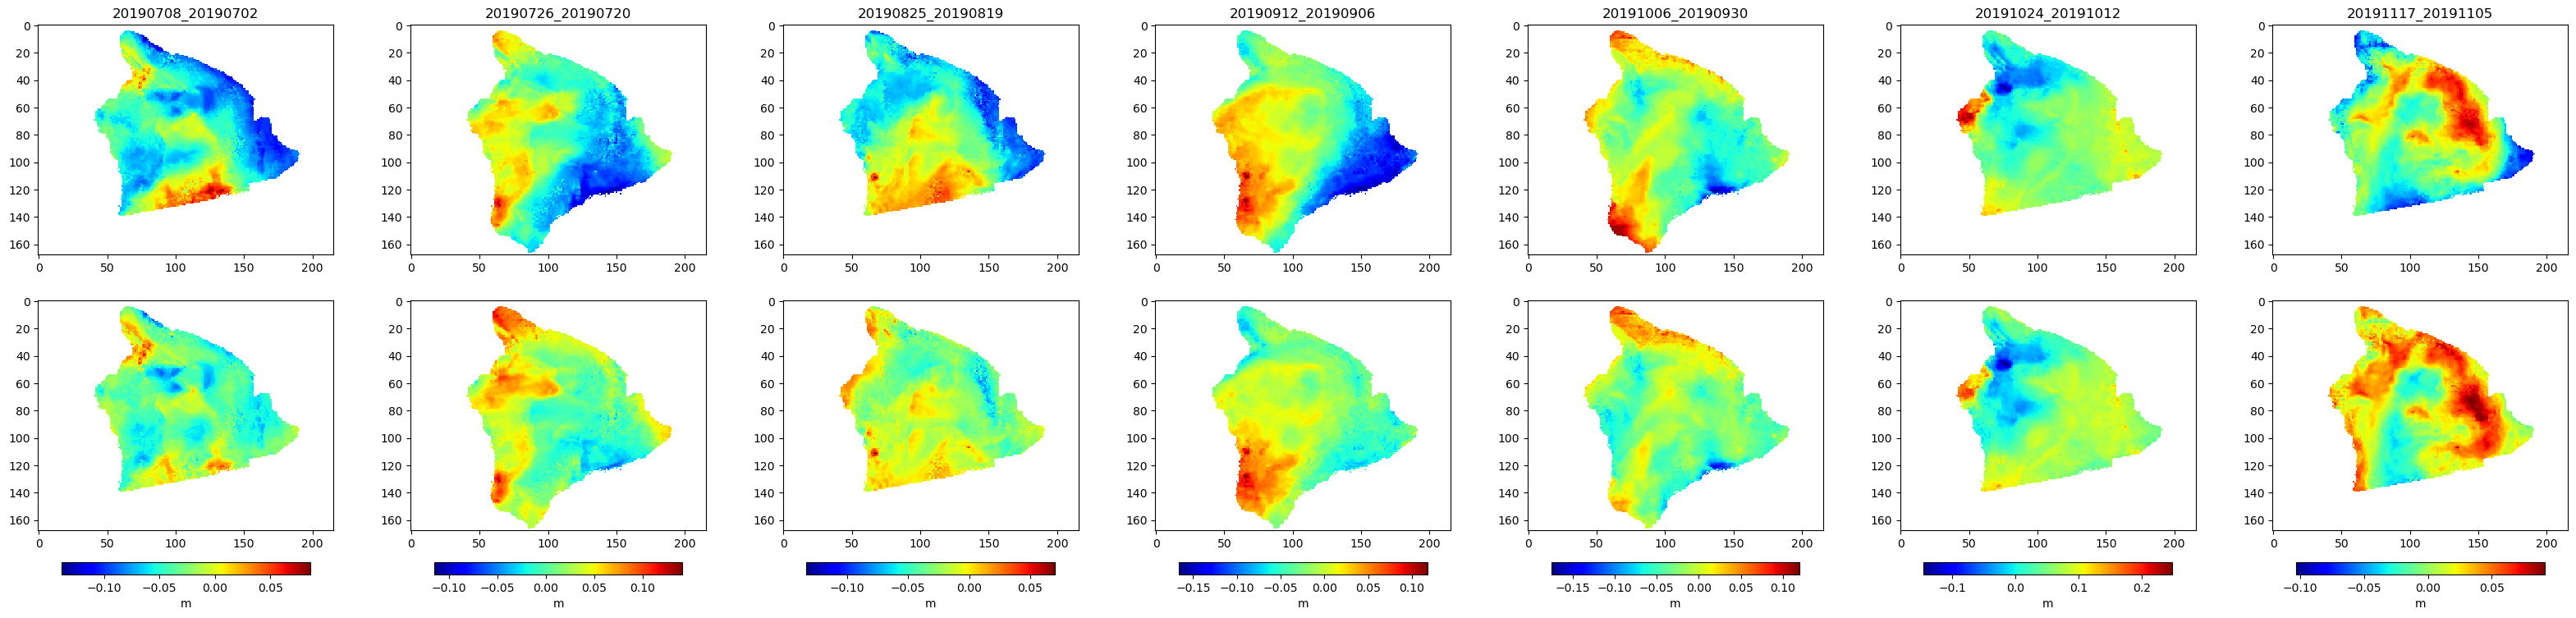

In [27]:
ifg_nn_Corr = []
fig, axes = plt.subplots(2, len(IFG), figsize=(40,10))
for i in range(len(IFG)):
    a = axes[0,i].imshow(IFG[i][::10,::10] - IFG[i][::10,::10][75,100], cmap='jet')
    # plt.colorbar(a, shrink=.7, pad=.05, label='m')
    axes[0,i].title.set_text(ifg_list[::4][i])
    b = axes[1,i].imshow((IFG[i][::10,::10] - IFG[i][::10,::10][75,100]) + (TD_list[i] - TD_list[i][75,100]), cmap='jet', vmin = np.nanmin(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]), vmax = np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]))
    fig.colorbar(a, ax=axes[:, i], shrink=0.8, pad=0.05, orientation='horizontal', label='m')
    ifg_nn_Corr.append((IFG[i][::10,::10] - IFG[i][::10,::10][75,100]) + (TD_list[i] - TD_list[i][75,100]))
plt.show()

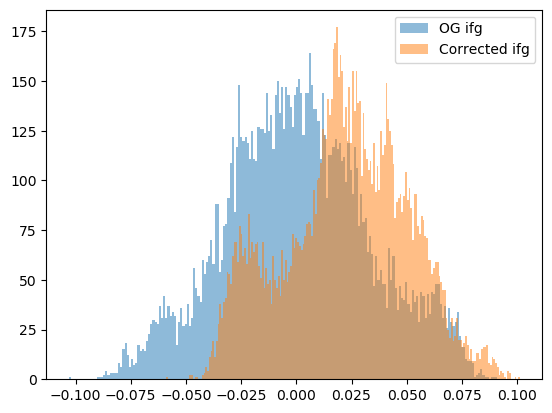

In [28]:
plt.hist((IFG[-1][::10,::10] - IFG[-1][::10,::10][75,100]).ravel(), bins=200, label='OG ifg', alpha=0.5)
plt.hist(((IFG[-1][::10,::10] - IFG[-1][::10,::10][75,100]) + (TD_list[-1] - TD_list[-1][75,100])).ravel(), bins=200, label='Corrected ifg', alpha=0.5)
plt.legend()
plt.show()

In [29]:
RAiDER_list = []
XY = np.meshgrid(x,y)
loc = np.hstack((XY[0].reshape(-1,1), XY[1][::-1].reshape(-1,1), dem[::10, ::10].ravel().reshape(-1,1)))
for i, date in enumerate(ifg_list[::4]):
    print(date)
    date1, date2 = get_datetime(date)
    wm1_1, wm1_2, minutes= getWM(date1, 'T04_31_00', weather_file_path)
    wm2_1, wm2_2, minutes= getWM(date2, 'T04_31_00', weather_file_path)
    hydro1, wet1 = interpByTime(wm1_1, wm1_2, minutes, 'hydro_total'), interpByTime(wm1_1, wm1_2, minutes, 'wet_total')
    hydro2, wet2 = interpByTime(wm2_1, wm2_2, minutes, 'hydro_total'), interpByTime(wm2_1, wm2_2, minutes, 'wet_total')
    
    hydro_total_1_interp = make_interpolator(hydro1)
    wet_total_1_interp = make_interpolator(wet1)
    hydro_total_2_interp = make_interpolator(hydro2)
    wet_total_2_interp = make_interpolator(wet2)
    # with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T04_00_00*[A-Z].nc'.format(date=date1)))) as wm:
    #     hydro_total_1_interp = make_interpolator(wm, 'hydro_total')
    #     wet_total_1_interp = make_interpolator(wm, 'wet_total')
    # with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T04_00_00*[A-Z].nc'.format(date=date2)))) as wm:
    #     hydro_total_2_interp = make_interpolator(wm, 'hydro_total')
    #     wet_total_2_interp = make_interpolator(wm, 'wet_total')
    
    hydro1 = hydro_total_1_interp(loc).reshape(dem[::10, ::10].shape)
    wet1 = wet_total_1_interp(loc).reshape(dem[::10, ::10].shape)
    hydro2 = hydro_total_2_interp(loc).reshape(dem[::10, ::10].shape)
    wet2 = wet_total_2_interp(loc).reshape(dem[::10, ::10].shape)
    td1 = hydro1 + wet1
    td2 = hydro2 + wet2
    TD = (td1 - td2)/ np.cos(np.radians(los[::10,::10]))
    RAiDER_list.append(TD)

20190708_20190702
20190726_20190720
20190825_20190819
20190912_20190906
20191006_20190930
20191024_20191012
20191117_20191105


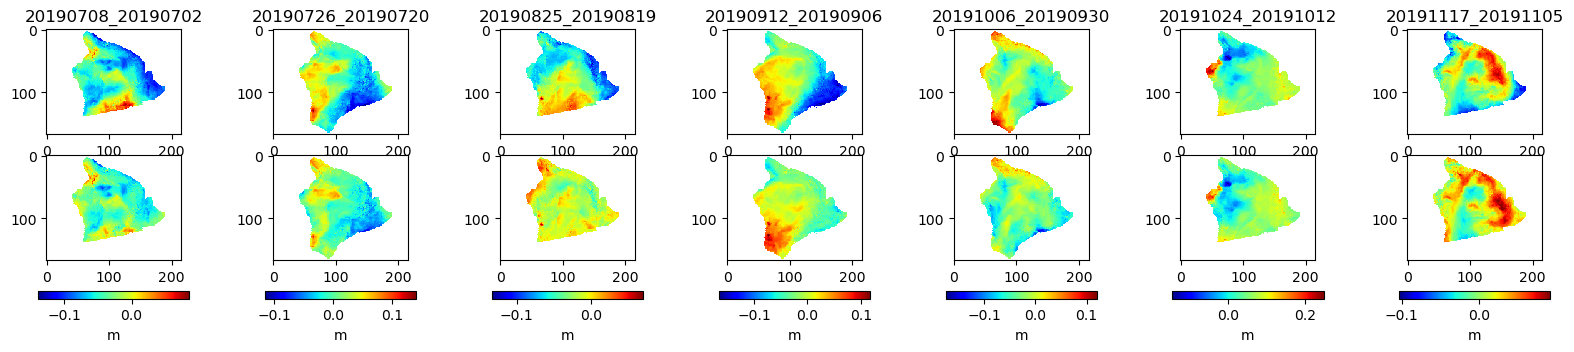

In [30]:
ifg_raider_Corr = []
fig, axes = plt.subplots(2, len(IFG), figsize=(20,4))
for i in range(len(IFG)):
    a = axes[0,i].imshow(IFG[i][::10,::10] - IFG[i][::10,::10][75,100], cmap='jet')
    # plt.colorbar(a, shrink=.7, pad=.05, label='m')
    axes[0,i].title.set_text(ifg_list[::4][i])
    b = axes[1,i].imshow((IFG[i][::10,::10] - IFG[i][::10,::10][75,100]) + (RAiDER_list[i] - RAiDER_list[i][75,100]), cmap='jet', vmin = np.nanmin(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]), vmax = np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]))
    fig.colorbar(a, ax=axes[:, i], shrink=0.8, pad=0.1, orientation='horizontal', label='m')
    ifg_raider_Corr.append((IFG[i][::10,::10] - IFG[i][::10,::10][75,100]) + (RAiDER_list[i] - RAiDER_list[i][75,100]))
plt.show()

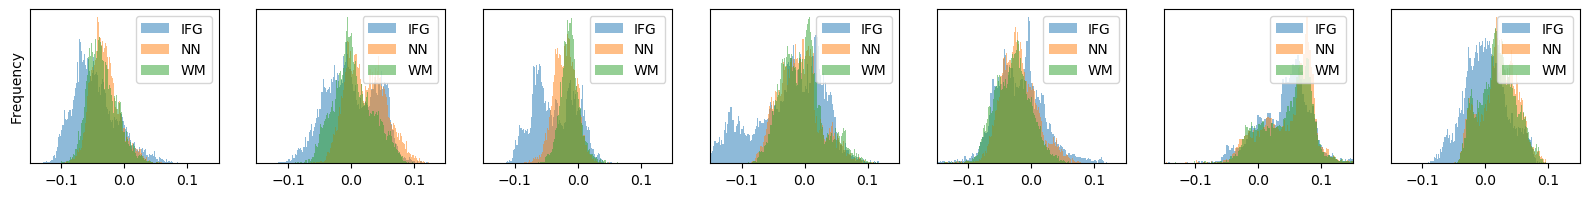

In [37]:
fig, axes = plt.subplots(1,len(IFG), figsize=(20,2))
for no in range(len(IFG)):
    axes[no].hist((IFG[no][::10,::10] - IFG[no][::10,::10][75,100]).ravel(), bins=150, label='IFG', alpha=0.5)
    axes[no].hist(ifg_nn_Corr[no].ravel(), bins=150, label='NN', alpha=0.5)
    axes[no].hist(ifg_raider_Corr[no].ravel(), bins=150, label='WM', alpha=0.5)
    # axes[no].set_xlabel('(m)', fontsize=10)
    if no == 0:
        axes[no].set_ylabel('Frequency', fontsize=10)
    axes[no].tick_params(axis='x', labelsize=10)
    axes[no].set_xlim(-0.15, 0.15)
    # axes[no].title.set_text(ifg_list[no])
    axes[no].set_yticks([])
    axes[no].legend(fontsize=10, loc='upper right')
fig.savefig('Plots/Hawaii/Hi_redisual_hist.png', dpi=250)
plt.show()

In [32]:
ifg_std = []
nn_std =[]
wm_std = []

for i in range(len(IFG)):
    og_ifg_std = np.nanstd(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]) 
    og_mae = np.nanmean(np.abs(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]))
    raider_corr_std = np.nanstd(ifg_raider_Corr[i]) 
    raider_mae = np.nanmean(np.abs(ifg_raider_Corr[i]))
    nn_corr_std = np.nanstd(ifg_nn_Corr[i])
    nn_mae = np.nanmean(np.abs(ifg_nn_Corr[i]))
    ifg_std.append(og_ifg_std)
    nn_std.append(nn_corr_std)
    wm_std.append(raider_corr_std)
    print(ifg_list[::4][i])
    print('Original ifg std:', og_ifg_std)
    # print('Original MAE:', og_mae)
    print('RAiDER corrected ifg std:', raider_corr_std)
    print('RAiDER percentage std change:', ((raider_corr_std-og_ifg_std)/og_ifg_std)*100)
    # print('RAiDER MAE:', raider_mae)
    print('Neural Network corrected ifg:', nn_corr_std)
    print('Neural Network percentage std change:', ((nn_corr_std-og_ifg_std)/og_ifg_std)*100)
    # print('Neural Network MAE:', nn_mae)
    

20190708_20190702
Original ifg std: 0.035424292
RAiDER corrected ifg std: 0.023252529743601515
RAiDER percentage std change: -34.35993107178996
Neural Network corrected ifg: 0.022156712
Neural Network percentage std change: -37.453338503837585
20190726_20190720
Original ifg std: 0.04081808
RAiDER corrected ifg std: 0.030929918419162716
RAiDER percentage std change: -24.22495573713708
Neural Network corrected ifg: 0.030937469
Neural Network percentage std change: -24.206458032131195
20190825_20190819
Original ifg std: 0.03357984
RAiDER corrected ifg std: 0.01497540731736753
RAiDER percentage std change: -55.40357917973013
Neural Network corrected ifg: 0.018021675
Neural Network percentage std change: -46.33186459541321
20190912_20190906
Original ifg std: 0.054092493
RAiDER corrected ifg std: 0.03337197166870155
RAiDER percentage std change: -38.305724372303175
Neural Network corrected ifg: 0.032497834
Neural Network percentage std change: -39.921727776527405
20191006_20190930
Original i

In [33]:
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=15)

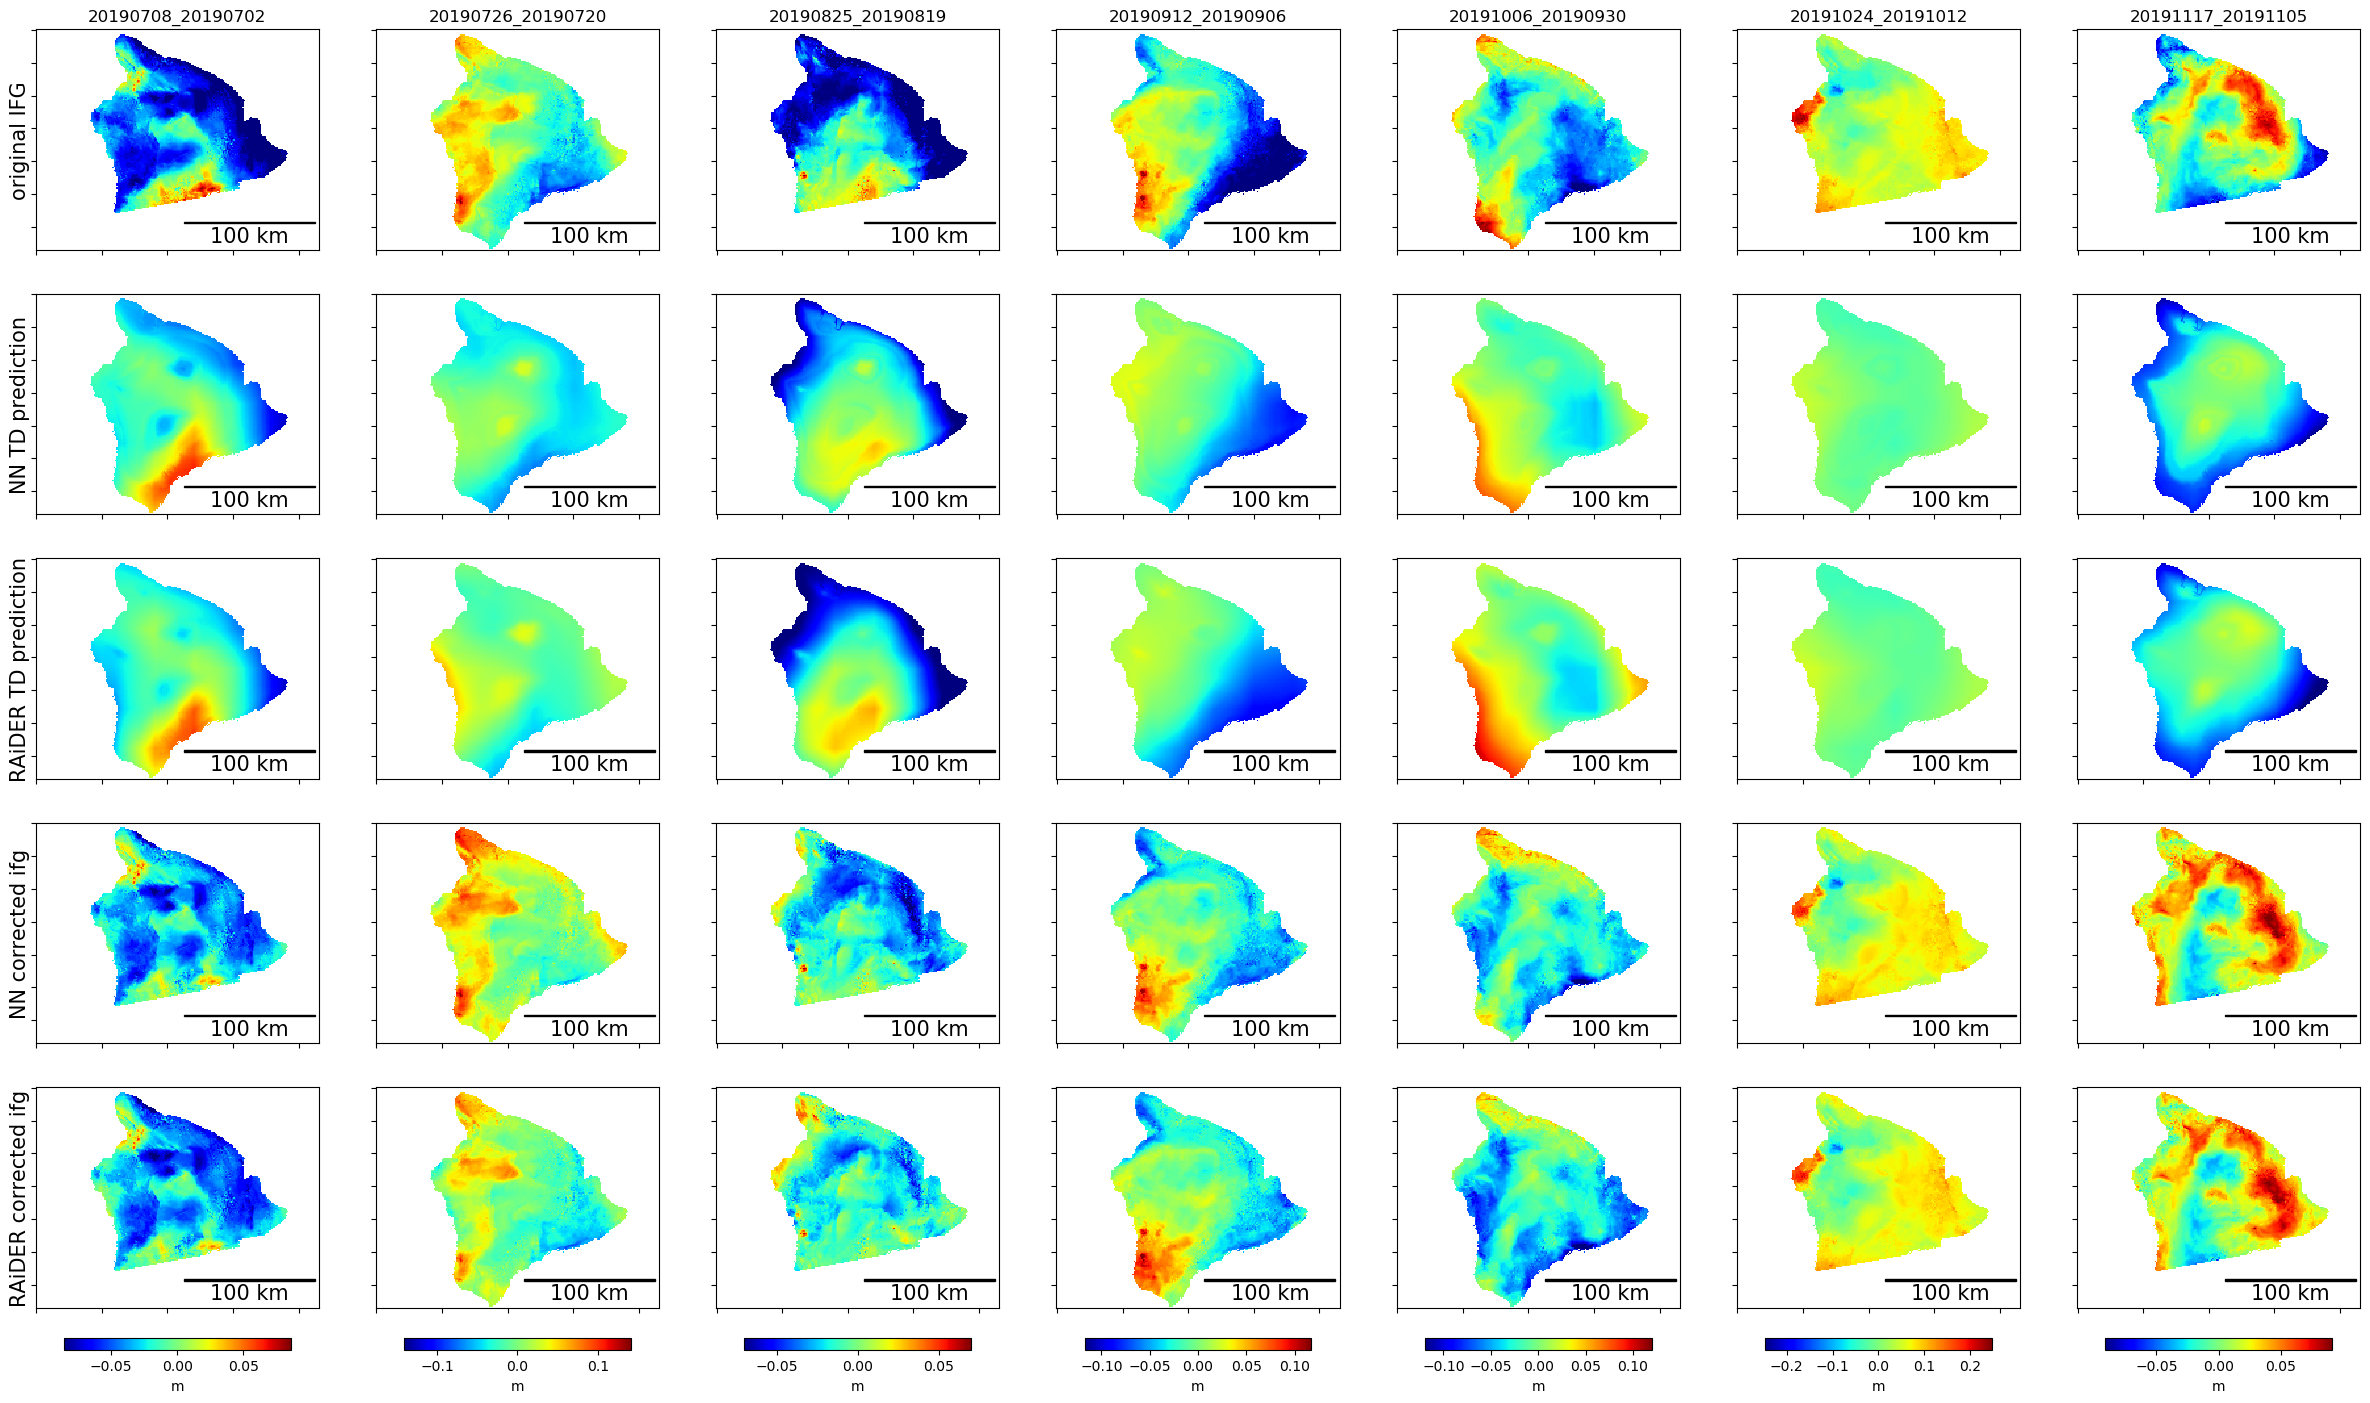

In [35]:
"""
RAiDER_list = List of RAiDER TD prediction of each ifg date
TD_list = List of NN TD prediction of each ifg date
ifg_nn_corr = List of NN corrected ifg of each ifg date
ifg_raider_corr = List of RAiDER corrected ifg of each ifg date
"""
ifg_raider_corr=[]
fig, axes = plt.subplots(5, len(ifg_list[::4]), figsize=(30,20))
for i in range(len(IFG)):
    a = axes[0,i].imshow(IFG[i][::10,::10] - IFG[i][::10,::10][75,100], cmap='jet', vmin = -np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]), vmax = np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]))
    axes[0,i].title.set_text(ifg_list[::4][i])
    b = axes[1,i].imshow(-TD_list[i]+TD_list[i][75,100], cmap='jet', vmin = -np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]), vmax = np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]))
    c = axes[2,i].imshow(-RAiDER_list[i]+RAiDER_list[i][75,100], cmap='jet', vmin = -np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]), vmax = np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]))
    d = axes[3,i].imshow(ifg_nn_Corr[i], cmap='jet', vmin = -np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]), vmax = np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]))
    e = axes[4,i].imshow(ifg_raider_Corr[i], cmap='jet', vmin = -np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100]), vmax = np.nanmax(IFG[i][::10,::10] - IFG[i][::10,::10][75,100])) 
    fig.colorbar(a, ax=axes[:, i], shrink=0.8, pad=0.02, orientation='horizontal', label='m')
    if i == 0:
        axes[0,i].set_ylabel('original IFG', fontsize=15)
        axes[1,i].set_ylabel('NN TD prediction', fontsize=15)
        axes[2,i].set_ylabel('RAiDER TD prediction', fontsize=15)
        axes[3,i].set_ylabel('NN corrected ifg', fontsize=15)
        axes[4,i].set_ylabel('RAiDER corrected ifg', fontsize=15)
    else:
        pass
    for c in range(0,5):
        axes[c,i].xaxis.set_tick_params(labelbottom=False)
        axes[c,i].yaxis.set_tick_params(labelleft=False)
        scalebar = AnchoredSizeBar(axes[c, i].transData,
                           100, '100 km', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

        axes[c,i].add_artist(scalebar)
plt.savefig('Plots/Hawaii/Hi_examp_ifg_corr_cleaned.png', dpi=250)
plt.show()

# Create GIF of the TD change with time and uncertainty

In [34]:
times = ['0','5','10','15','20','25','30','35', '40','45', '50','55']
# times = ['0','10','20','30','40','50']

20190708_20190702
  68/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  67/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  77/1134 [=>............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  69/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  66/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  67/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  64/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  65/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  69/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  72/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  74/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  68/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  75/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  76/1134 [=>............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  81/1134 [=>............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  66/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  73/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  71/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  76/1134 [=>............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  78/1134 [=>............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  75/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  77/1134 [=>............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step
20190708_20190702
  66/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  72/1134 [>.............................] - ETA: 1s

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1134/1134 [==============================] - 2s 1ms/step


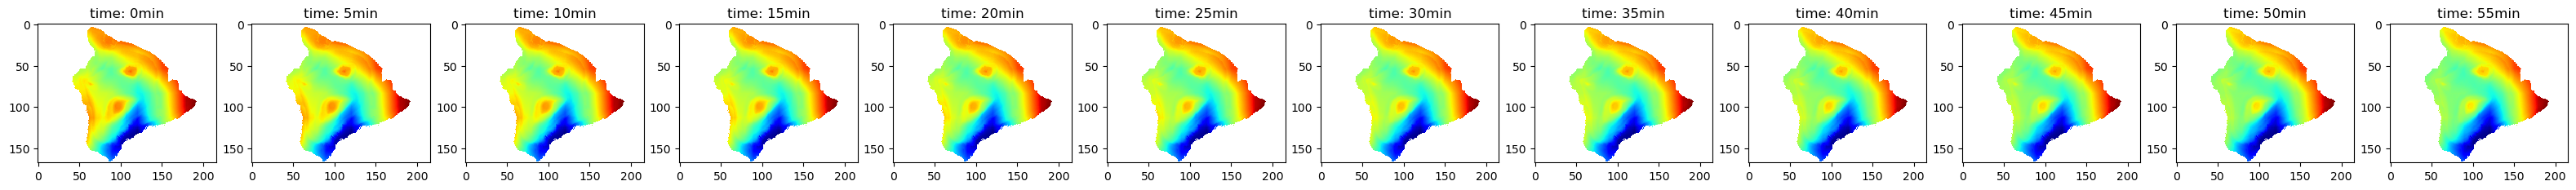

In [35]:
TD_time_list = []
fig, axes = plt.subplots(1, len(times), figsize=(40,15))
for i, time in enumerate(times):
    date=ifg_list[0]
    print(date)
    # print('Reading in ...')

    # print('IFG - done!')
    if i == 0:
        ifg, grid = focus_bound(uw_ifg + date, lon_min, lat_min, lon_max,
                            lat_max)
        dem, dem_grid = Resamp_rasterio('../InSAR/Hawaii/products/Extracted/DEM/SRTM_3arcsec_uncropped.tif', lon_min,
                                        lat_min, lon_max,
                                        lat_max, ifg)
        # print('DEM - done!')
        mask = dem<=0
        lon = dem_grid[:,0].reshape(ifg.shape)
        lat = dem_grid[:,-1].reshape(ifg.shape)
        dem[mask] = np.nan
        x = lon[::10,::10][0,:]
        x.sort()
        y = lat[::10,::10][:,0]
        y.sort()
        XY = np.meshgrid(x,y)    
        los, _ = Resamp_rasterio('../InSAR/Hawaii/Angle/los.rdr', lon_min, lat_min, lon_max, lat_max, ifg)
    else:
        pass
    # print('LOS - done!')
    # print('DEM: ', dem_grid[0:5])
    # Create a mask for IFG
    
    # lat[mask] = np.nan
    
    # Get all the x,y coordinate
    # x = list(set(grid[:, 0]))
    # x.sort()
    # y = list(set(grid[:, 1]))
    # y.sort()
    
    # # Get date and wm
    date1, date2 = get_datetime(date)
    wm1_1, wm1_2, minutes= getWM(date1, 'T04_{}_00'.format(time), weather_file_path)
    wm2_1, wm2_2, minutes= getWM(date2, 'T04_{}_00'.format(time), weather_file_path)
    P1, T1, e1 = interpByTime(wm1_1, wm1_2, minutes, 'all')
    P2, T2, e2 = interpByTime(wm2_1, wm2_2, minutes, 'all')
    P1, T1, e1 = P1.interp(x=x, y=y), T1.interp(x=x, y=y), e1.interp(x=x, y=y)
    P2, T2, e2 = P2.interp(x=x, y=y), T2.interp(x=x, y=y), e2.interp(x=x, y=y)

    # print('Make data array for ML prediction...')
    Day_1 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    Day_2 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    # print('Done!')
    # print('')
    # print('Make prediction...')
    predict_day1 = model.predict(scaler.transform(Day_1))
    predict_day2 = model.predict(scaler.transform(Day_2))
    TD = (predict_day1 - predict_day2).reshape(dem[::10,::10].shape)
    TD = TD / np.cos(np.radians(los[::10,::10]))
    TD_time_list.append(TD)
    # print('Done!')
    
    axes[i].imshow(TD, cmap='jet')
    # axes[i].xlabel('Lon')
    # axes[i].ylabel('Lat')
    # axes[i].axis("off")
    # axes[i].colorbar(label='Total Delay (m)')
    axes[i].title.set_text('time: '+ time + 'min')
plt.show()
    

In [36]:
import matplotlib.pyplot as plt
import imageio

In [37]:
def create_frame(t,i):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(t-t[75,100], cmap = 'jet', vmin=-0.06, vmax=0.06)
    plt.title(times[i]+ ' min',
              fontsize=14)
    plt.colorbar(label='m')
    plt.savefig('./img/img_{}.png'.format(i), 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()

In [38]:
for i, t in enumerate(TD_time_list):
    create_frame(t, i)

In [39]:
frames = []
for t in range(len(times)):
    image = imageio.v2.imread(f'./img/img_{t}.png')
    frames.append(image)

In [40]:
imageio.mimsave('./TD_time.gif', # output gif
                frames,          # array of input frames
                fps = 4)         # optional: frames per second

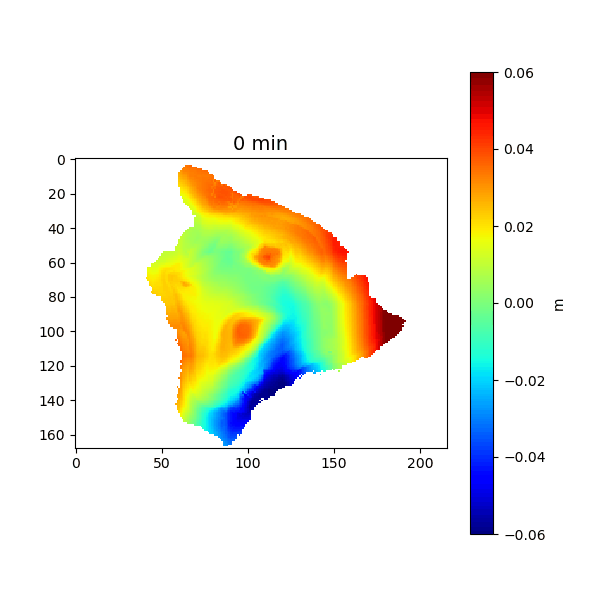

In [41]:
from PIL import Image
im = Image.open('TD_time.gif')
im